## Before usage
Remember to change the directory to your own drive path. The link can be found on https://drive.google.com/drive/folders/1SnwZ1C7byMqM5JzPYVmHWUP69hkM-6ob?usp=sharing

In [1]:
# Include the paths to load the file. Change this to your own directory
data_source_path = '../RA_source_localization/data.npz'

In [2]:
import numpy as np
from scipy.linalg import eigh
from tqdm import tqdm
import matplotlib.pyplot as plt
import imot_tools.io.s2image as s2 # imot_tools only works with python version <= 3.7
from bluebild import *


# README of the dataset
===============================================================

`data.npz` contains real pre-processed data from the LOFAR radio-telescope observing the BOOTES field during 8 hours.

Note: a Short-Time-Interval (STI) corresponds to 8 seconds.

* XYZ: (N_time, N_antenna, 3) antenna positions per STIs
* W: (N_time, N_antenna, N_antenna) recorded beamforming weights per STI
* S: (N_time, N_antenna, N_antenna) recorded visibilities per STI
* px_grid: (N_px, 3) cartesian coordinates of the sky region to estimate. (HEALPIX tesselation)
* lambda_: observation wavelength
* catalog: (N_src, 3) cartesian coordinates of the major sources present in the field.

You may find the ImoT-tools library [1] useful for plotting spherical images.

[1] https://pypi.org/project/ImoT-tools/


In [3]:
data = np.load(data_source_path)
n_time, n_antenna, _ = np.shape(data['XYZ'])
n_px, _  = np.shape(data['px_grid'])
n_src, _ = np.shape(data['catalog'])
time_step = 8   # unit [s]
print(f"Loading preprocessed LOFAR radio-telescope data...\n\
Number of time samples: {n_time}\n\
Number of Antennas: {n_antenna}\n\
Number of pixels of sky: {n_px}\n\
Number of major light sources: {n_src}\n\
Signal wavelength: {data['lambda_']}\n\
Sampled with time interval: {time_step} secs")

Loading preprocessed LOFAR radio-telescope data...
Number of time samples: 3595
Number of Antennas: 24
Number of pixels of sky: 27524
Number of major light sources: 100
Signal wavelength: 2.067534193103448
Sampled with time interval: 8 secs


In [4]:
def intensity_plot(intensity, catalog, ax=None, star_size=50, linewidth=0.5):
    img = s2.Image(intensity, data['px_grid'].T) # averaged by time
    axe, proj, scm = img.draw(use_contours=True,
                            data_kwargs={'cmap': 'jet'},
                            catalog=catalog.T,
                            ax=ax,
                            catalog_kwargs={'s': star_size, 'edgecolors': 'w','marker': '*', 'linewidths': linewidth})
    if ax is None:
        fig = plt.gcf()
        fig.set_dpi(200)

### Generate data
First generate a ground truth of intensity function

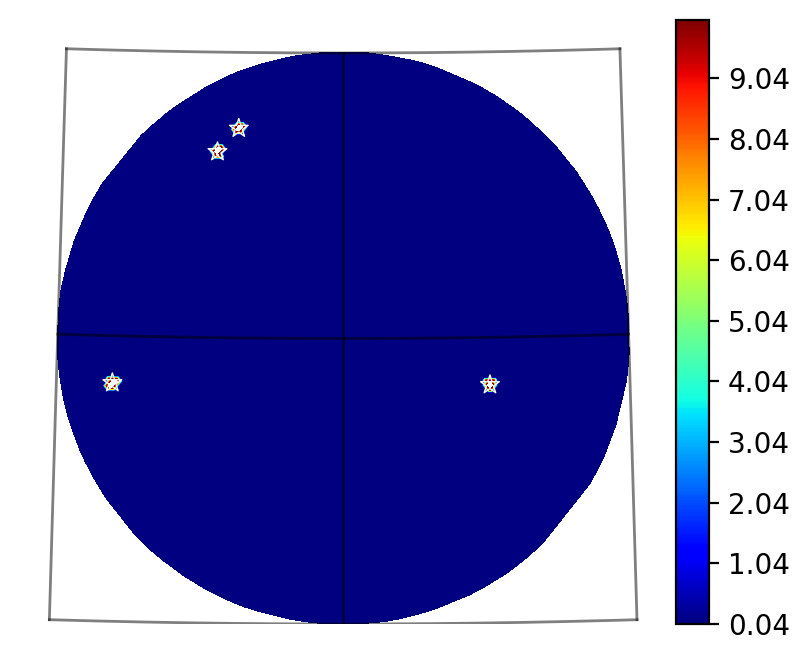

In [5]:
star_size = 7e-4
star_idx = [30, 56, 65, 75] # choose the indices of star from the catalog
time_duration = 50 # number of time frames
sig_energy = 10
SNR = 200
noise_energy = sig_energy/SNR

# Initialize
time = np.arange(0, time_duration*time_step, time_step, dtype=float)
C = 3e8
wavelength = data['lambda_']

# Find the location of star on px_grid
star_pos = data['catalog'][star_idx,:]

pos_on_grid = np.zeros(n_px, dtype=bool)
for pos in star_pos:
    dim_check = np.zeros((n_px, 3), dtype=bool)
    for i in range(3):
        dim_check[:,i] = np.logical_and(data['px_grid'][:,i] > pos[i]-star_size, data['px_grid'][:,i] < pos[i]+star_size)
    current_star_pos_idx = np.logical_and(dim_check[:,0], dim_check[:,1])
    current_star_pos_idx = np.logical_and(current_star_pos_idx, dim_check[:,2])

    pos_on_grid = np.logical_or(pos_on_grid, current_star_pos_idx)
# pos_on_grid is the indexing array to locate the light parts

# Generating intensity function across the sky
intensity = pos_on_grid.astype(float)*sig_energy + (1-pos_on_grid.astype(float))*noise_energy
intensity_plot(intensity, star_pos)

Using the ground trugh instensity to generate the raw observation of antennas $X$

In [6]:
# Assign gaussian background noise to all points
light_source = np.random.randn(time_duration, n_px) + 1j*np.random.randn(time_duration, n_px)
light_source *= np.tile(np.sqrt(intensity), (time_duration, 1))

time_shift = np.reshape(np.exp(2j*np.pi*C/wavelength*time), (time_duration, 1))
light_source *= np.tile(time_shift, (1, n_px)) # shape=(time_duration, n_px)

# Generate X : shape = (time_duration, n_antenna)
X = np.zeros((time_duration, n_antenna), dtype=complex)
for t in tqdm(range(time_duration)):
    phase_shift = data['XYZ'][t, :, :] @ data['px_grid'].T  # shape=(n_antenna, n_px)
    phase_shift = np.exp(-2j*np.pi/wavelength*phase_shift)
    X[t,:] = np.sum(light_source[t,:] * phase_shift, axis=1)

X.shape

100%|██████████| 50/50 [00:01<00:00, 27.11it/s]


(50, 24)

Obtain the beamformed data $Y$ and the visibility function $S$ as the correlation of $Y$

In [7]:
Y = np.zeros_like(X, dtype=complex) # shape=(time_duration, n_antenna)
visibility = np.zeros((time_duration, n_antenna, n_antenna), dtype=complex)
for t in tqdm(range(time_duration)):
    Y[t,:] = data['W'][t,:,:].conj().T @ X[t,:]
    vec = np.reshape(Y[t,:], (n_antenna, 1))
    visibility[t,:,:] = vec @ vec.conj().T / n_antenna
    
print(visibility.shape)

100%|██████████| 50/50 [00:02<00:00, 22.06it/s]

(50, 24, 24)


Use the generated data to estimate the original intensity distribution

In [8]:
estimated_intensity = bluebild_long_exposure(visibility, data['W'], data['XYZ'], data['px_grid'], data['lambda_'], 0.5)
print(np.mean(estimated_intensity))

Calculate intensity from 0 with length 50. Threshold = 0.5


100%|██████████| 50/50 [00:04<00:00, 12.15it/s]

12.999905543119912


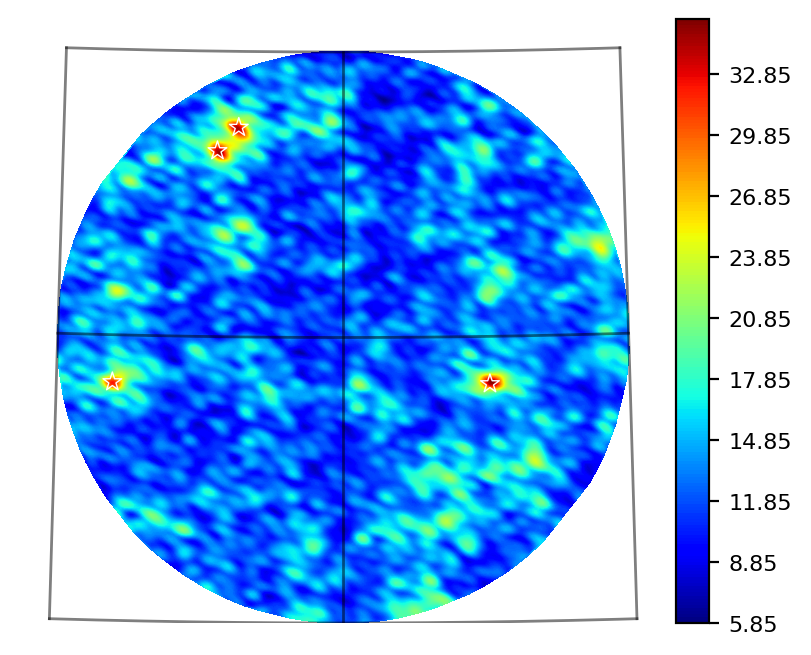

In [9]:
plt.rcParams.update({'font.size': 8})
intensity_plot(estimated_intensity, catalog=star_pos)

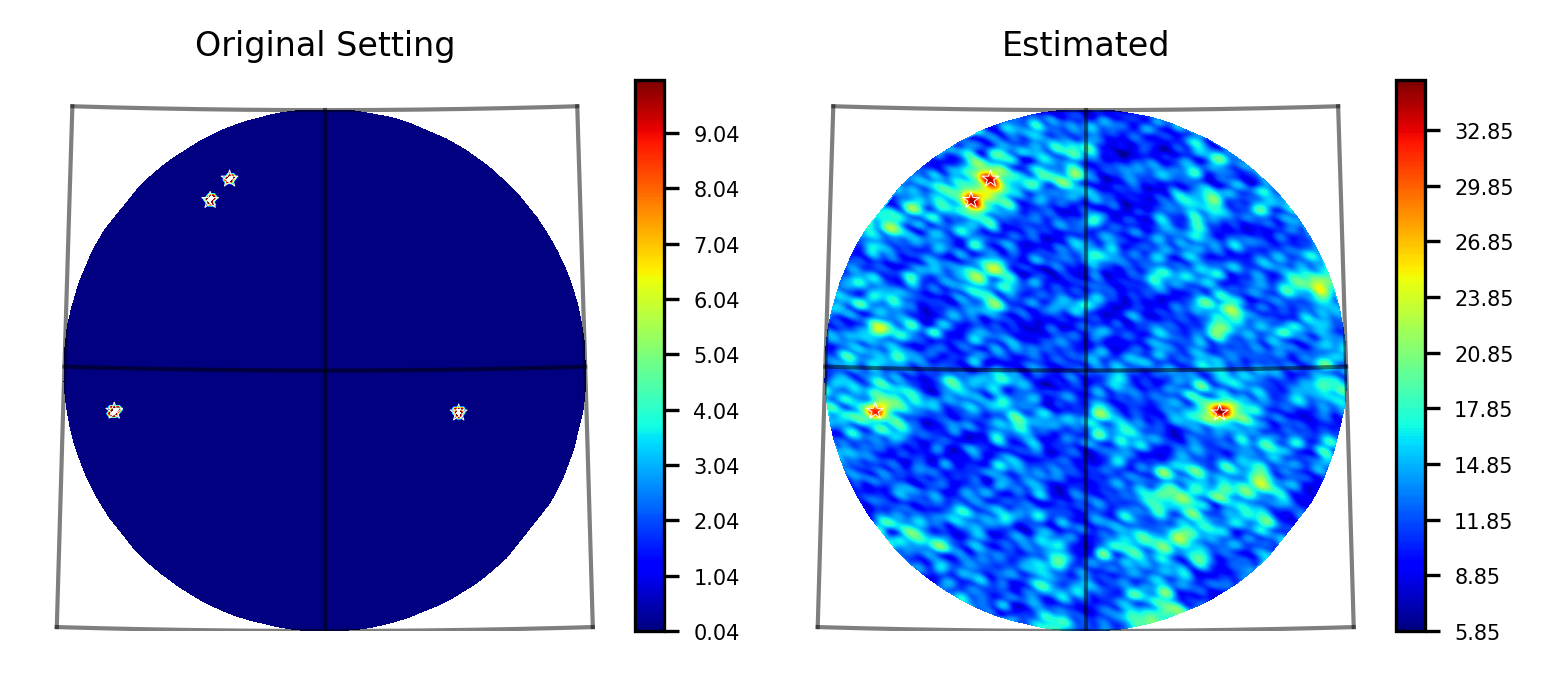

In [10]:
fig, axs = plt.subplots(1,2)
fig.set_dpi(300)
fig.set_size_inches(6,12)
title_fontsize = 8
plt.rcParams.update({'font.size': 5})

axs[0].set_title('Original Setting', fontsize=title_fontsize)
axs[1].set_title('Estimated', fontsize=title_fontsize)

star_size=18
linewidth=0.25
intensity_plot(intensity, star_pos, axs[0], star_size=star_size, linewidth=linewidth)
intensity_plot(estimated_intensity, star_pos, axs[1], star_size=star_size, linewidth=linewidth)
